# Project: Data Analysis and House price prediction

### Dimitrios Reppas / dhmhtrhsreppas@gmail.com

#### Libraries and complementary functions:

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import random
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns', None)

# Set the seed for NumPy random number generator
np.random.seed(0)

# Set the seed for Python built-in random number generator
random.seed(0)
random_seed = 0 # for ML models

In [32]:
# function for dropping duplicate houses coming from different agents
def drop_dup(input_df):
    df = input_df
    not_null_mask = df.notnull()
    no_null_cols = df.columns[not_null_mask.all()].drop(['id', 'ranking_score']) # use the all() method along the columns axis to check which columns have no null values plus drop 'id', 'ranking_score'.
    df['for_dup'] = "" # create an extra column to help on finding duplicates 
    
    for i in no_null_cols:
        df['for_dup'] = df['for_dup'] + df[i].astype(str)
        
    df = df.drop_duplicates(subset='for_dup')
    df = df.drop(columns=['for_dup']) # drop the complementary column
    return df

# This function is for a primary cleaning of data. The comments bellow show exacly the steps that are followed
def data_prim_clean(input_df):
    df.dropna(axis = 0, subset = ["floor", "agent_id"], inplace = True) # remove NAs from agent_id, floor as this is information we want to have and only a small % of the data will be dropped
    df.drop(columns=['equipped','energy_class','accessible_for_disabled'], inplace = True) # drop the whole 'equipped','energy_class','accessible_for_disabled' as the % of NAs is great
    df['agent_id'] = df['agent_id'].astype('Int64')  # change agent_id and renovation_year from float to int
    df['renovation_year'] = df['renovation_year'].astype('Int64')
    # change all boolean to int-binary
    # My assumption is that for values in binary columns, the NA is a 0.
    for i in df.select_dtypes(include=object):
        try:
            df[i].replace({False: 0, True: 1}, inplace=True)
            df[i] = df[i].astype('Int64')
            df[i] = df[i].fillna(0)
        except:
            pass
    df.loc[df['year_of_construction'] == 2155, 'year_of_construction'] = 2023 # Change all the 'year_of_construction' = 2155 to 2023
    df.loc[df['renovation_year'].isna(), 'renovation_year'] = df['year_of_construction'] # If there is no reconstraction, 'renovation_year' = 'year_of_construction'
    df['home_years'] = 2023 - df['renovation_year'] # create new comlumn that provides more information about how new a home is. The smaller the newer
    df.drop(columns=['year_of_construction', 'renovation_year'], inplace = True) # There is no need for 'year_of_construction','renovation_year' any more
    return df

# This function is used to evaluate the prediction of 3 models
def evaluate_predictions_of_prices():
    model_create_funcs = {
    "GradientBoostingRegressor": Pipeline([('preprocessor', preprocessor),('model', GradientBoostingRegressor(random_state=random_seed))]),
    "RandomForestRegressor": Pipeline([('preprocessor', preprocessor),('model', RandomForestRegressor(random_state=random_seed))]),
    "XGBRegressor": Pipeline([('preprocessor', preprocessor),('model', xgb.XGBRegressor(random_state=random_seed))])
    
    }

    results = {}

    for name, create_func in model_create_funcs.items():
  
    # Create model
      model = create_func
      # Train model
      model.fit(X_train, y_train)

      # Make predictions on test set
      predicted_prices = model.predict(X_test)
      # Convert predictions
      # Get metrics on test set
      rmse = mean_squared_error(predicted_prices, y_test, squared = False)
      mape = mean_absolute_error(predicted_prices, y_test) 

      # Make predictions on train set
      predicted_prices = model.predict(X_train)
      # Get metrics on train set
      train_rmse = mean_squared_error(predicted_prices, y_train, squared = False)
      train_mape = mean_absolute_error(predicted_prices, y_train) 

      results[name] = {
          "rmse" : rmse.round(2),
          "mape" : mape.round(2),
          "train_rmse" : train_rmse.round(2),
          "train_mape" : train_mape.round(2)
      }
    print(results)
# This function is used to obtain n important features from the data, when 3 different models are fitted to them.
def most_important(n_features=20):
    model_create_funcs = {
    "GradientBoostingRegressor": Pipeline([('preprocessor', preprocessor),('model', GradientBoostingRegressor(random_state=random_seed))]),
    "RandomForestRegressor": Pipeline([('preprocessor', preprocessor),('model', RandomForestRegressor(random_state=random_seed))]),
    "XGBRegressor": Pipeline([('preprocessor', preprocessor),('model', xgb.XGBRegressor(random_state=random_seed))])
    
    }
    results_top_feat = {}

    for name, create_func in model_create_funcs.items():
      model = create_func
      # Train model
      model.fit(X_train, y_train)
      feature_importances = model.named_steps['model'].feature_importances_
      importances_descending = sorted(zip(feature_importances, X_train.columns), reverse=True)
      top_features = [feat[1] for feat in importances_descending][:n_features]
      results_top_feat[name] = {
          "top_features" : top_features}
    print(results_top_feat)
    return results_top_feat
# This function is used to obtain the common important features direved from the 3 models
def common_features(important_feat):
    common_features = set(important_feat['GradientBoostingRegressor']['top_features'])
    for key in important_feat:
        common_features.intersection_update(important_feat[key]['top_features'])

    common_features_list = list(common_features)
    return common_features_list
# This function is used to evaluate the prediction of 3 models, when only the common important attributes are passed through the models.
def evaluate_predictions_of_prices_for_top_features():
    model_create_funcs = {
        "GradientBoostingRegressor": Pipeline([('preprocessor', preprocessor),('model', GradientBoostingRegressor(random_state=random_seed))]),
        "RandomForestRegressor": Pipeline([('preprocessor', preprocessor),('model', RandomForestRegressor(random_state=random_seed))]),
        "XGBRegressor": Pipeline([('preprocessor', preprocessor),('model', xgb.XGBRegressor(random_state=random_seed))])
    
    }

    results = {}

    for name, create_func in model_create_funcs.items():
  
      # Create model
      model = create_func
      # Train model
      model.fit(X_train, y_train)

      # Make predictions on test set
      predicted_prices = model.predict(X_test)
      # Convert predictions
      # Get metrics on test set
      rmse = mean_squared_error(predicted_prices, y_test, squared = False)
      mape = mean_absolute_error(predicted_prices, y_test) 

      # Make predictions on train set
      predicted_prices = model.predict(X_train)
      # Get metrics on train set
      train_rmse = mean_squared_error(predicted_prices, y_train, squared = False)
      train_mape = mean_absolute_error(predicted_prices, y_train) 

      results[name] = {
          "rmse" : rmse.round(2),
          "mape" : mape.round(2),
          "train_rmse" : train_rmse.round(2),
          "train_mape" : train_mape.round(2)
      }
    print(results)

### Context
SpaN is a company that provides an online portal for real estate services. The main functionality of the portal is that property listings are published by real estate agents and visitors can search for properties based on a set of search criteria.

As a memeber of the Data Analysis team of SpaN, you closely cooperate with various departments to assist in decision making and strategy execution, based on actionable insights that you get out of data.

The following assignment consists of 3 parts:

### The dataset
The given dataset is this month’s snapshot of all the listings of residential properties (houses) for sale listed on the portal of SpaN for 4 specific areas of Athens (geography_name). Each listing has a unique id but it can be the case that the same actual property is uploaded by multiple real estate agents so multiple different listings (with different ids) for the same property are created. Each agent is identified by a unique agent_id .

The rank that listings are ordered by in a specific area when a user makes a search depends on the type of the listing (ad_type) and their listing score (ranking_score). There are four different listing types: simple listings, that appear last, “UP” listings that rank above simple, “PREMIUM” listings that rank above “UP”, and “STAR” listings that appear at the top of the list. Within each listing type group properties are ranked based on the listing score.

The size of the property (sq_meters), its price and the area (geography_name) are the main search filters that visitors use in their initial search. The rest of the columns of the dataset are all further attributes of the properties listed and can be used as filters on a search. The year_of_construction column represents the year that the house was built and the value 2155 means that the house is under construction.

### Assignment Part 1
The marketing department wants to issue a press release regarding house prices in different areas of Athens. They ask if you could help them by providing some useful statistics that would show the price levels of houses for sale this month that real estate journalists would find useful.

For this purpose, you will need to calculate tables that show some metrics, namely the mean, median and standard deviation of property prices_per_sq_meter per house type (subtype) and per area (geography_name). Before you calculate the final metrics, keep in mind that you should clean the dataset from any entries that you think should not be included in the analysis, because they will corrupt the right image of the price_per_sq_meter levels of each area.

#### Basic exploratory analysis, feature extraction and cleaning of data

In [33]:
# Import and the data
df = pd.read_csv('assignment_rev2.csv')
df

,id,ranking_score,agent_id,geography_name,sq_meters,price,year_of_construction,floor,subtype,rooms,no_of_bathrooms,energy_class,renovation_year,no_of_wc,ad_type,living_rooms,kitchens,balcony_area,lux_home,new_development,garage,furnished,preserved,investment,unfinished,equipped,heating_under_floor,renovated,requires_renovation,airy,bright,painted,garden,ac,storage,balcony,internal_stairs,view,secure_door,penthouse,alarm,corner,accessible_for_disabled,holiday_home,student_home,night_power,neoclassic,double_glass,for_commercial_use,fireplace,elevator,satellite,solar_heater,attic,pool,playroom
0,42911697,47.0,14680.0,northern sub,567,200000,2005,1,apartment,4,0,NaN,NaN,0,simple,0,0,0,NaN,NaN,True,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,43018583,134.7,15502.0,northern sub,642,550000,1992,ground-floor,detached,5,4,NaN,NaN,1,simple,1,1,0,False,False,True,False,False,False,False,NaN,False,False,False,False,False,False,True,False,True,True,True,True,False,False,False,True,NaN,False,False,False,False,True,False,True,True,False,False,True,False,True
2,39670968,71.0,9807.0,northern sub,320,500000,2009,ground-floor,detached,2,2,NaN,NaN,1,simple,0,0,0,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
3,39740833,122.0,14682.0,northern sub,95,230000,2007,1,apartment,3,1,NaN,NaN,1,simple,0,1,0,False,False,True,False,False,False,False,NaN,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,NaN,False,False,False,False,True,False,True,True,False,False,False,False,False
4,39742998,126.7,14682.0,northern sub,195,370000,2007,ground-floor,maisonette,4,1,NaN,NaN,2,simple,0,1,0,False,False,True,False,False,False,False,NaN,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,NaN,False,False,False,False,True,False,True,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15442,43079210,101.0,19009.0,beesy neighborhood,80,75000,1960,3,apartment,2,0,NaN,NaN,0,simple,0,0,0,False,False,False,False,False,False,False,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,NaN,False,False,False,False,NaN,NaN,False,False,False,False,False,False,False
15443,43079212,103.5,19009.0,beesy neighborhood,69,70000,1975,2,apartment,2,0,NaN,NaN,0,simple,0,0,0,False,False,False,False,False,False,False,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,NaN,False,False,False,False,NaN,NaN,False,False,False,False,False,False,False
15444,43079508,118.1,6976.0,beesy neighborhood,75,120000,1974,3,apartment,1,1,NaN,NaN,0,simple,0,0,0,False,False,False,False,False,False,False,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,NaN,False,False,False,False,True,False,False,False,False,False,False,False,False
15445,40498665,78.7,7354.0,beesy neighborhood,800,600000,1930,ground-floor,building,1,0,NaN,NaN,0,simple,0,0,0,False,False,False,False,False,False,False,NaN,False,False,False,False,False,False,False,False,False,False,NaN,False,False,False,False,False,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False


In [34]:
#Important info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15447 entries, 0 to 15446
Data columns (total 56 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       15447 non-null  int64  
 1   ranking_score            15447 non-null  float64
 2   agent_id                 15343 non-null  float64
 3   geography_name           15447 non-null  object 
 4   sq_meters                15447 non-null  int64  
 5   price                    15447 non-null  int64  
 6   year_of_construction     15447 non-null  int64  
 7   floor                    14715 non-null  object 
 8   subtype                  15447 non-null  object 
 9   rooms                    15447 non-null  int64  
 10  no_of_bathrooms          15447 non-null  int64  
 11  energy_class             2107 non-null   object 
 12  renovation_year          2067 non-null   float64
 13  no_of_wc                 15447 non-null  int64  
 14  ad_type               

In [35]:
df = drop_dup(df) # drop duplicate houses
df = data_prim_clean(df) # Primary cleaning of data
df

,id,ranking_score,agent_id,geography_name,sq_meters,price,floor,subtype,rooms,no_of_bathrooms,no_of_wc,ad_type,living_rooms,kitchens,balcony_area,lux_home,new_development,garage,furnished,preserved,investment,unfinished,heating_under_floor,renovated,requires_renovation,airy,bright,painted,garden,ac,storage,balcony,internal_stairs,view,secure_door,penthouse,alarm,corner,holiday_home,student_home,night_power,neoclassic,double_glass,for_commercial_use,fireplace,elevator,satellite,solar_heater,attic,pool,playroom,home_years
0,42911697,47.0,14680,northern sub,567,200000,1,apartment,4,0,0,simple,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18
1,43018583,134.7,15502,northern sub,642,550000,ground-floor,detached,5,4,1,simple,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1,31
2,39670968,71.0,9807,northern sub,320,500000,ground-floor,detached,2,2,1,simple,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,14
3,39740833,122.0,14682,northern sub,95,230000,1,apartment,3,1,1,simple,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,16
4,39742998,126.7,14682,northern sub,195,370000,ground-floor,maisonette,4,1,2,simple,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15439,43078794,143.9,8510,beesy neighborhood,104,115000,3,apartment,2,1,1,simple,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,58
15440,43079136,92.5,19009,beesy neighborhood,52,33000,semi-basement,apartment,1,0,0,simple,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53
15441,43079140,97.7,19009,beesy neighborhood,56,52000,1,apartment,1,0,0,simple,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59
15442,43079210,101.0,19009,beesy neighborhood,80,75000,3,apartment,2,0,0,simple,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63


##### Let's take a closer look on the columns we use for the assignment 1 with the following figures:
- Categorical variable

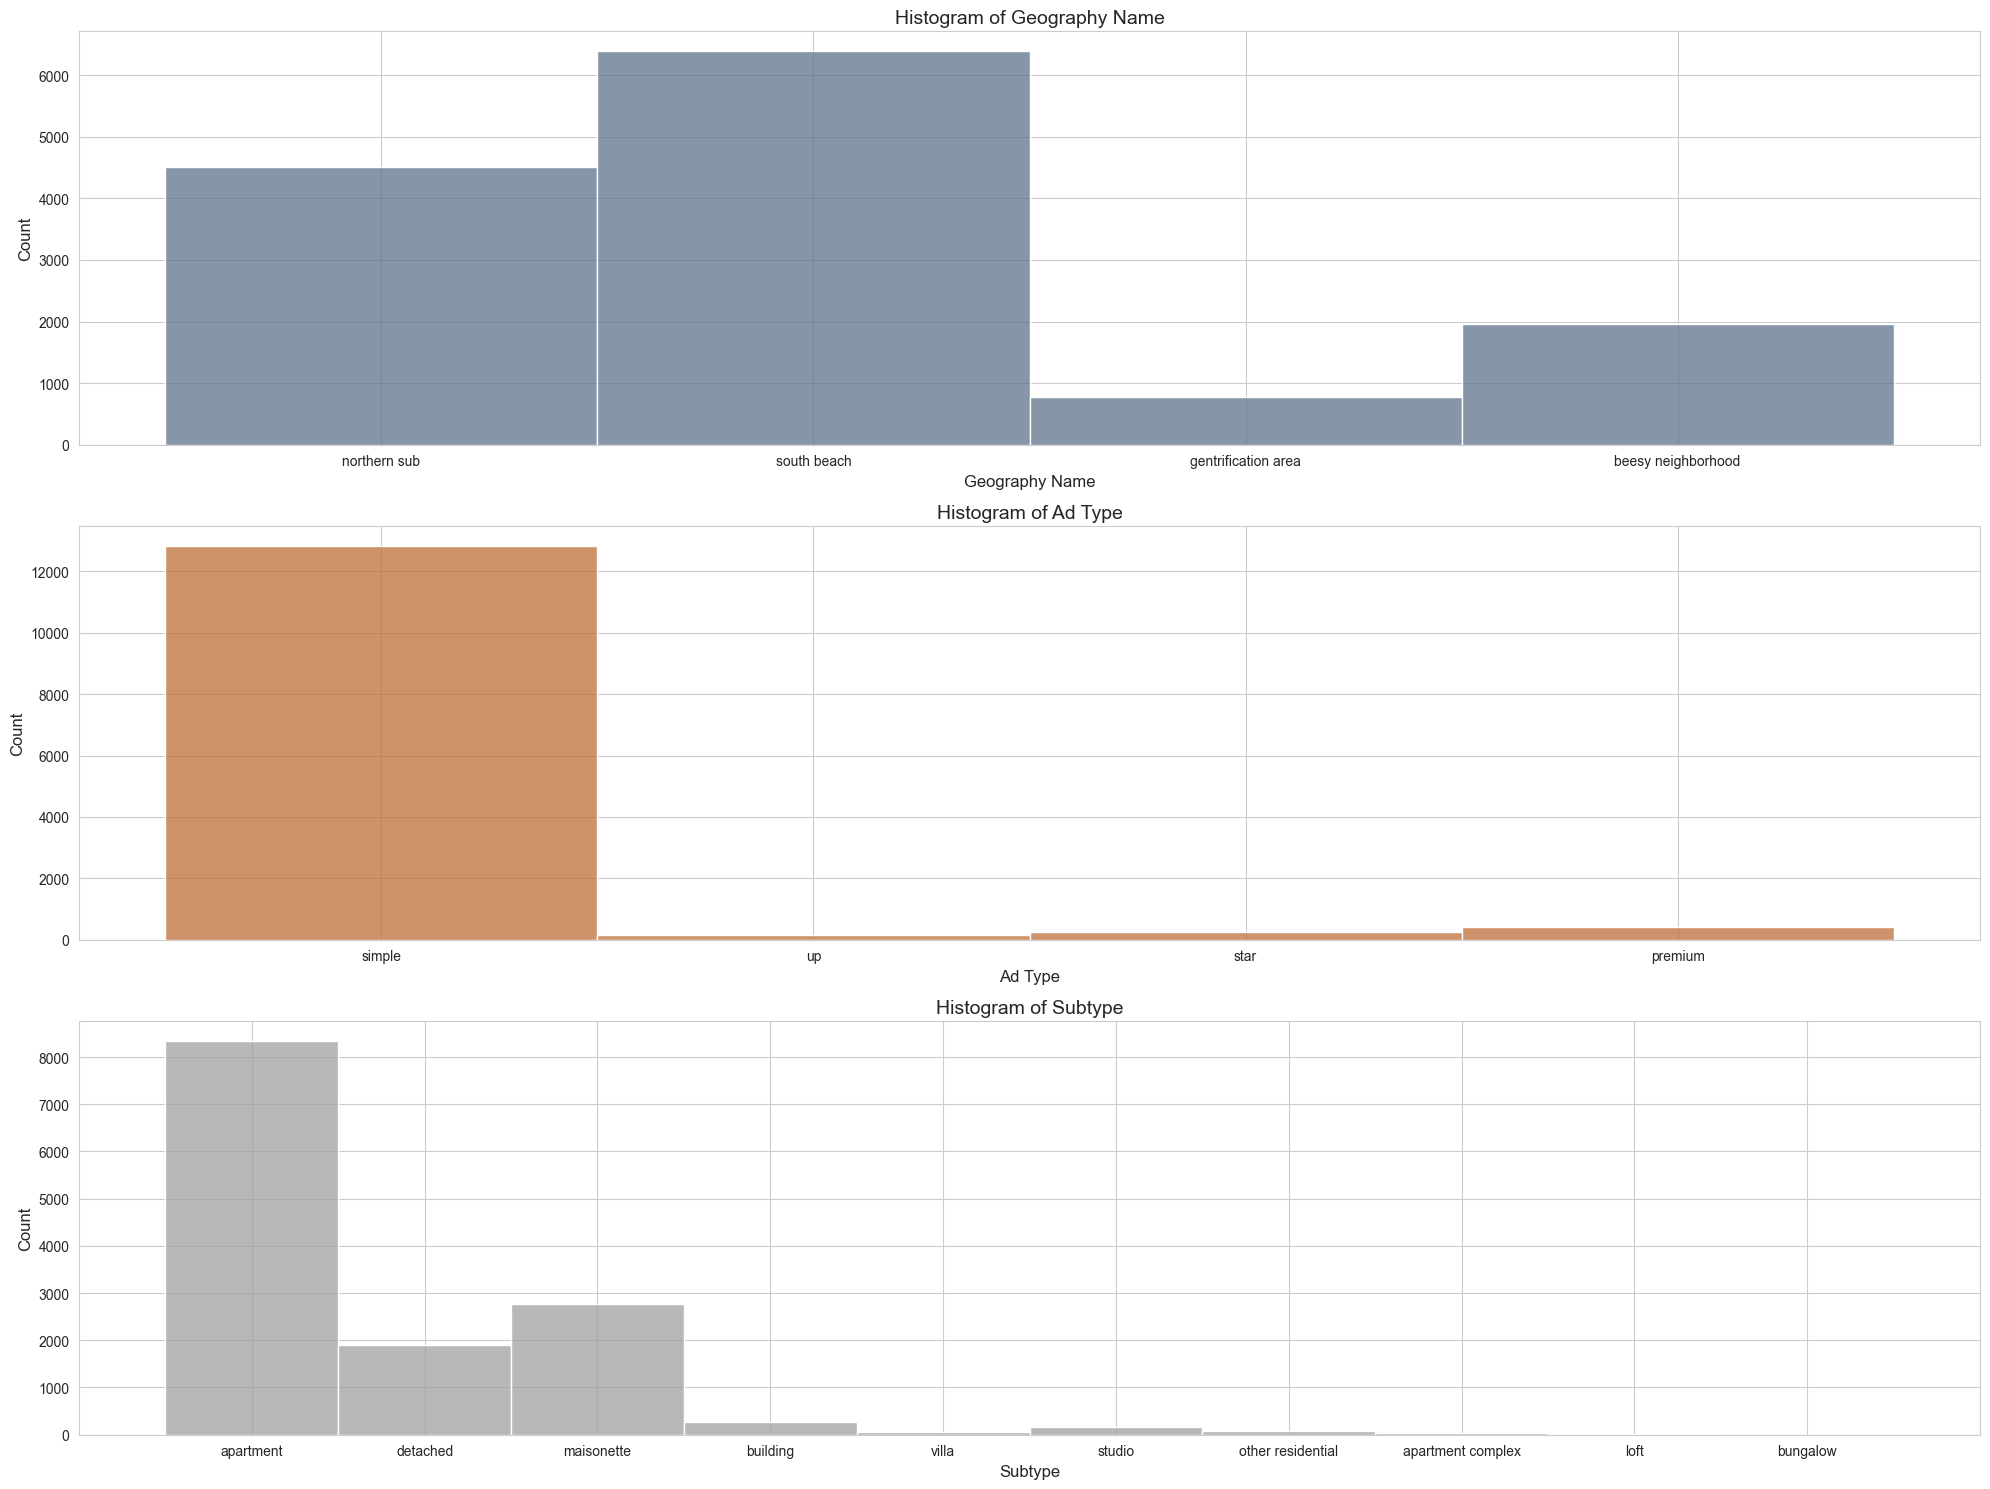

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
sns.histplot(data=df, x='geography_name', ax=ax[0], color='#5E738B')
ax[0].set_xlabel('Geography Name', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Histogram of Geography Name', fontsize=14)

sns.histplot(data=df, x='ad_type', ax=ax[1], color='#BF6F3B')
ax[1].set_xlabel('Ad Type', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)
ax[1].set_title('Histogram of Ad Type', fontsize=14)

sns.histplot(data=df, x='subtype', ax=ax[2], color='#A0A19F')
ax[2].set_xlabel('Subtype', fontsize=12)
ax[2].set_ylabel('Count', fontsize=12)
ax[2].set_title('Histogram of Subtype', fontsize=14)

plt.tight_layout()
plt.show()

##### Quick discussion 
- There is great imbalance between the categories

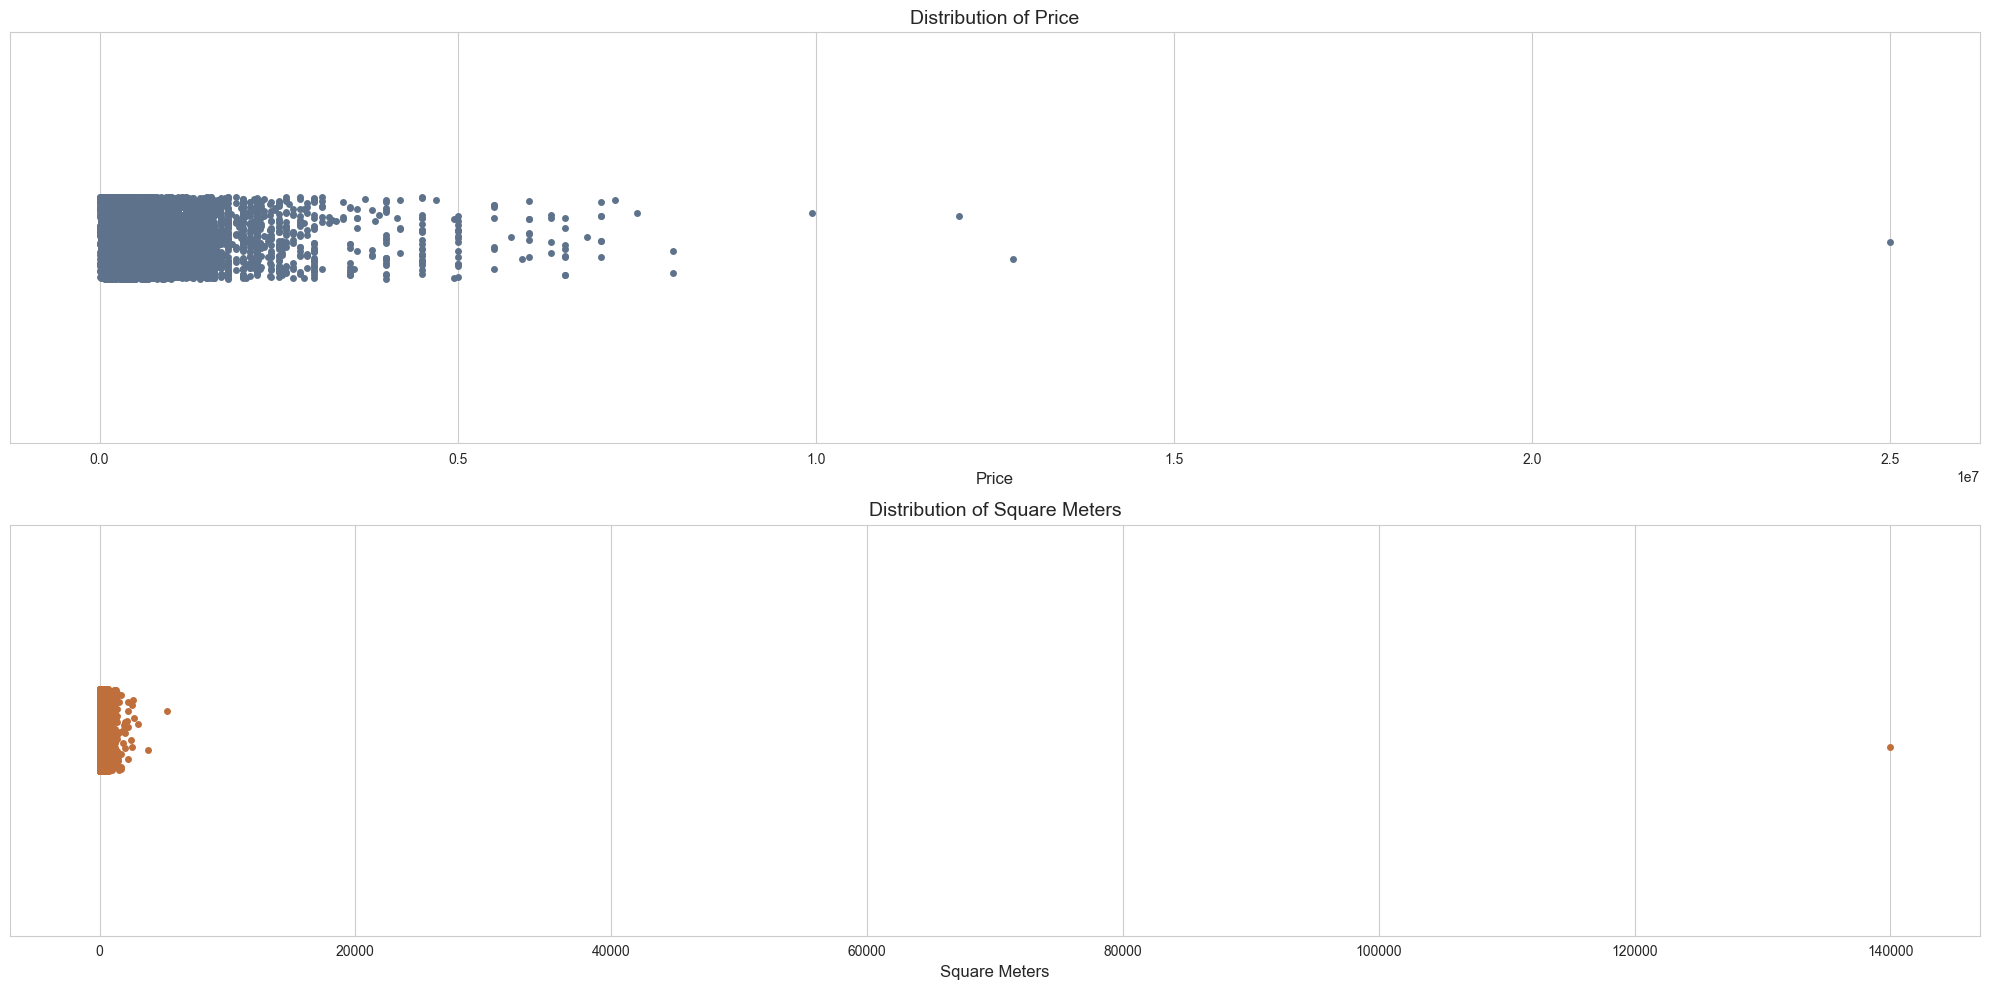

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.stripplot(x=df['price'], ax=ax[0], color='#5E738B')
ax[0].set_xlabel('Price', fontsize=12)
ax[0].set_title('Distribution of Price', fontsize=14)

sns.stripplot(x=df['sq_meters'], ax=ax[1], color='#BF6F3B')
ax[1].set_xlabel('Square Meters', fontsize=12)
ax[1].set_title('Distribution of Square Meters', fontsize=14)

plt.tight_layout()
plt.show()

##### Quick discussion 
- It is obvious that there are outliers in both Figures

##### Facing outliers
- I choose to face outliers based on z-score

The z-score measures how many standard deviations an observation is from the mean, and observations with a z-score greater than a certain threshold (e.g. 3) can be considered outliers and removed or transformed.


In [38]:
# remove outliers based on z-score

df = df[(np.abs(stats.zscore(df[['price', 'sq_meters']])) < 3).all(axis=1)]
df.reset_index(drop = True, inplace = True)

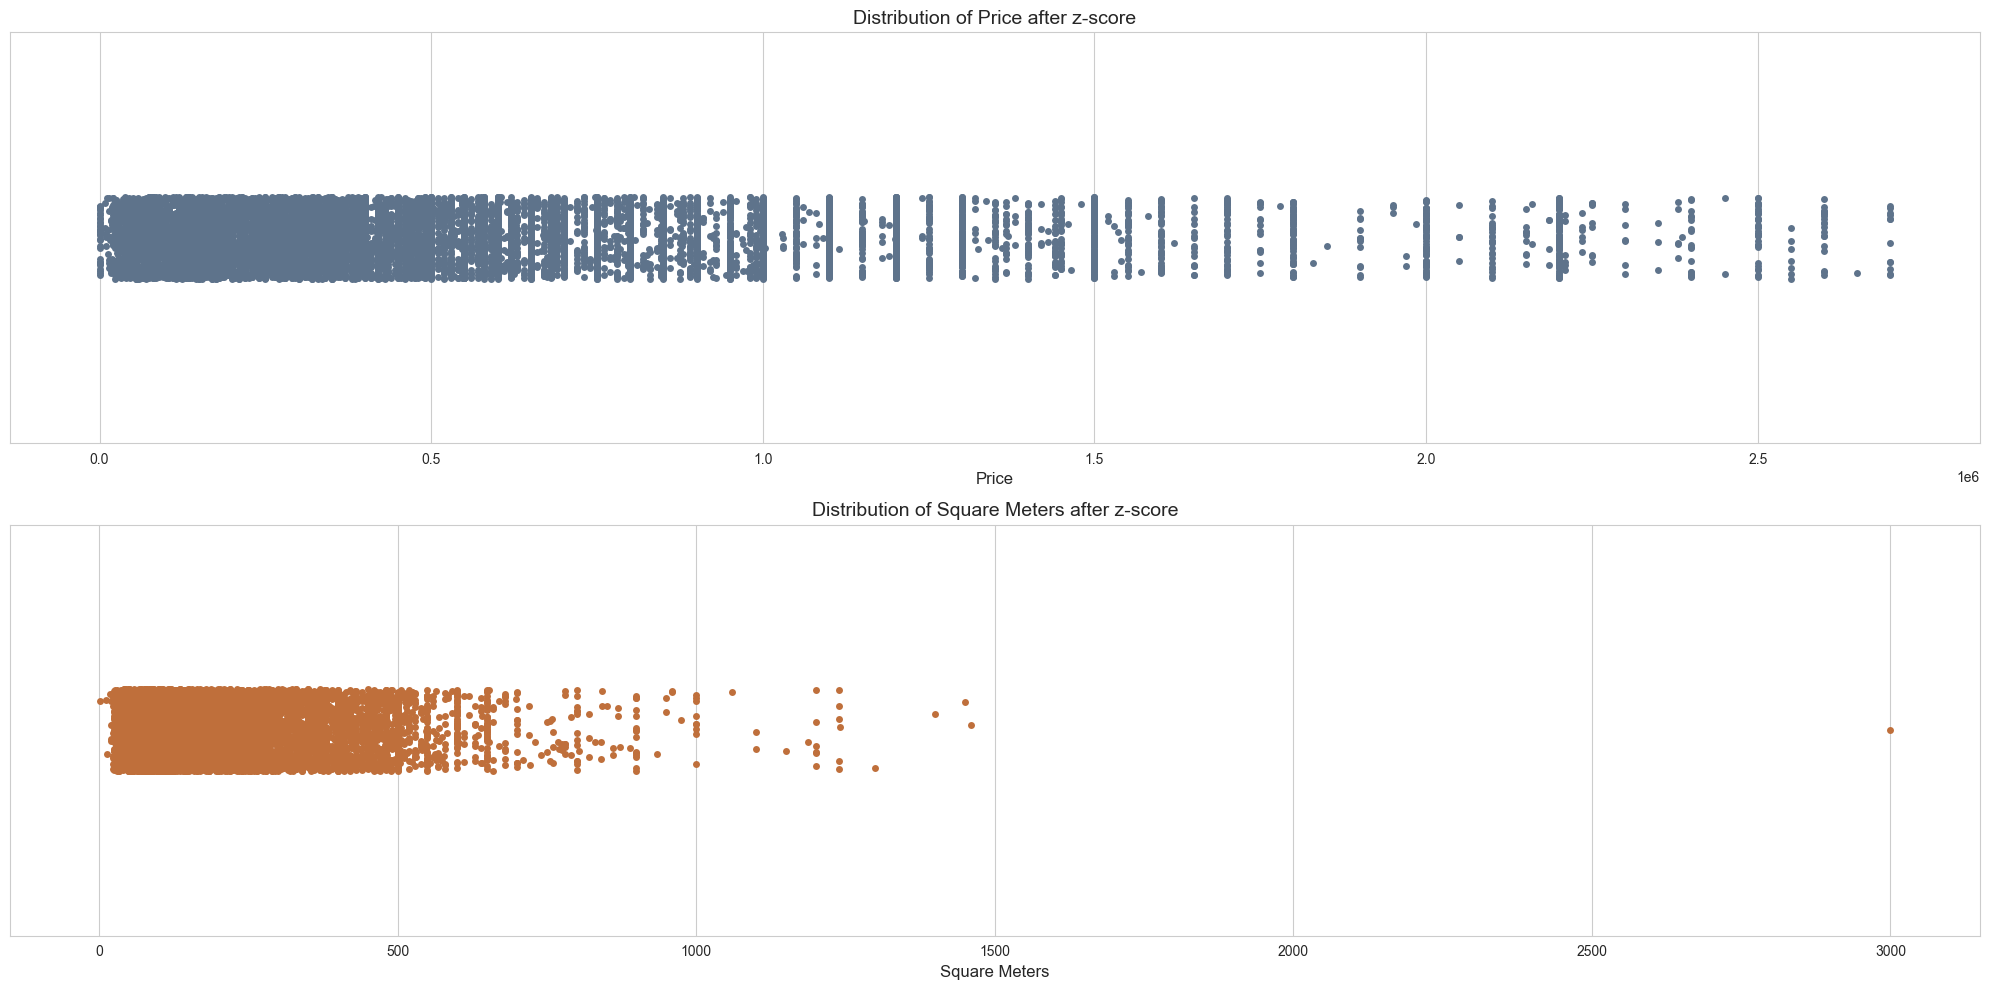

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.stripplot(x=df['price'], ax=ax[0], color='#5E738B')
ax[0].set_xlabel('Price', fontsize=12)
ax[0].set_title('Distribution of Price after z-score', fontsize=14)

sns.stripplot(x=df['sq_meters'], ax=ax[1], color='#BF6F3B')
ax[1].set_xlabel('Square Meters', fontsize=12)
ax[1].set_title('Distribution of Square Meters after z-score', fontsize=14)

plt.tight_layout()
plt.show()

##### Calculation of mean, median and standard deviation of property prices_per_sq_meter per house type (subtype) and per area (geography_name)

In [40]:
df['prices_per_sq_meter'] = df['price']/df['sq_meters'] # create 'prices_per_sq_meter' and clean in it from outliers in order to calculate the metrics
df = df[(np.abs(stats.zscore(df[['prices_per_sq_meter']])) < 3).all(axis=1)]
df.reset_index(drop = True, inplace = True)

In [41]:
# Group by subtype
subtype_summary = df.groupby('subtype')['prices_per_sq_meter'].agg(['mean', 'median', 'std']).round(2)

# Group by geography name
geography_summary = df.groupby('geography_name')['prices_per_sq_meter'].agg(['mean', 'median', 'std']).round(2)

# Group by subtype and geography name
combined_summary = df.groupby(['subtype', 'geography_name'])['prices_per_sq_meter'].agg(['mean', 'median', 'std']).round(2)

# Print output with fancy formatting
print(f"\n{'*'*65}\n{' '*15}Summary Statistics by Subtype\n{'*'*65}")
print(subtype_summary.to_string())

print(f"\n{'*'*65}\n{' '*15}Summary Statistics by Geography Name\n{'*'*65}")
print(geography_summary.to_string())

print(f"\n{'*'*65}\n{' '*15}Summary Statistics by Subtype and Geography Name\n{'*'*65}")
print(combined_summary.to_string())


*****************************************************************
               Summary Statistics by Subtype
*****************************************************************
                      mean   median      std
subtype                                     
apartment          2840.06  2678.57  1404.05
apartment complex  2144.06  1851.35  1105.17
building           1888.96  1675.00  1049.03
bungalow           2216.67  2216.67    70.71
detached           2867.32  2512.82  1596.00
loft               4112.50  4457.14  1268.62
maisonette         3162.58  2669.54  1567.59
other residential  2750.47  2313.73  1743.64
studio             1696.29  1547.92   968.25
villa              2445.90  2295.60   910.40

*****************************************************************
               Summary Statistics by Geography Name
*****************************************************************
                        mean   median      std
geography_name                                
bee

In [42]:
df.drop(columns=['prices_per_sq_meter'], inplace = True) # drop the 'prices_per_sq_meter' because it is not needed in the next stages

### Assignment Part 2
The Sales Manager of SpaN, after conducting qualitative research, by asking different agents in each area in Athens, wants to examine the possibility of offering special discounts for some listing types, based on the competitiveness of each area. To decide what type of discount should be given to agents in each area she would need to see an analysis of the competitiveness of each area.

A highly competitive area would mean that it would be hard for a simple listing to rank high in the search results of this area just by having a high ranking score.

To help the sales manager decide the level of discount to be given to agents in each area, you would need to:
- Identify and calculate some competitiveness metrics that would show the level of difficulty for a listing to rank high in a specific area
- Plot those metrics in graphs that you believe would convey the right information to the sales manager, to be able to make the right decisions

## Solution 

Undoubtedly, the discount rate should be proportional to the level of competitiveness. The higher the competitiveness, the higher the discount should be.

The calculation of competitiveness metrics (CV_metric) I propose is based on the following factors:

- CV_listings: There is more competition for high rankings among listings when there are more listings in an area.

- CV_price: The more expensive a house is, the less likely it is to be bought. Due to this, it is important to measure the variance of the price from the average price of the data set.

- CV_score_distribution: The distribution of scores in an area indicates that listings face difficulty standing out and ranking highly if they are highly concentrated in a narrow range. If there are many high-quality listings in an area, it would be challenging for a simple listing to rank high. In other words, for a standard mean value of score, for an area, the smaller the std, the bigger the competition!

#### CV_listings 

In [43]:
# count the number of listings in each area
ga_counts = df.groupby('geography_name')['id'].count().reset_index()
ga_counts.rename(columns={'id': 'counts'}, inplace=True)

# maximum number of listings in any area
max_num = ga_counts['counts'].max()

# competitiveness metric based on number of listings
ga_counts['CV_listings'] = ga_counts['counts'] / max_num
ga_counts = ga_counts.sort_values('CV_listings', ascending=False)

CV_listings_summary = ga_counts.loc[:, ['geography_name', 'CV_listings']].round(2)
CV_listings_summary

,geography_name,CV_listings
3,south beach,1.00
2,northern sub,0.69
0,beesy neighborhood,0.31
1,gentrification area,0.12


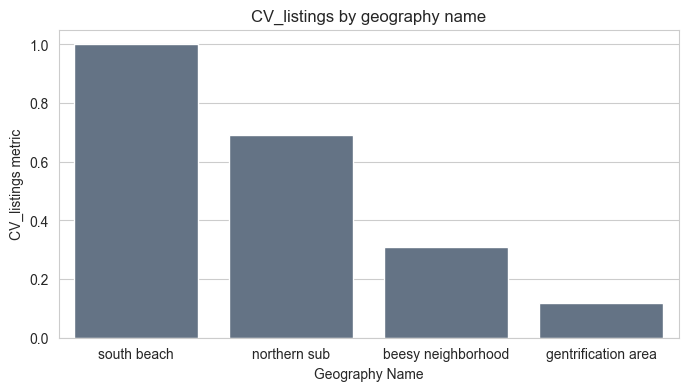

In [44]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 4))
sns.barplot(data=CV_listings_summary, x='geography_name', y='CV_listings', color='#5E738B')

# add labels
plt.xlabel('Geography Name')
plt.ylabel('CV_listings metric')
plt.title('CV_listings by geography name')

# show the plot
plt.show()

##### Discussion 
- Based on this metric South beach and Northern sub are the two most competitive areas, therefore there is a need for bigger discount

#### CV_price

In [45]:
# total number of listings and the average price for each geographic area
ga_price = df.groupby('geography_name')['price'].agg(['count', 'mean']).reset_index()

# percentage difference between the average price in each area and the overall average price for all areas
ga_price['price_diff'] = (ga_price['mean'] - df['price'].mean()) / df['price'].mean()

# normalize the percentage difference values to be between 0 and 1
ga_price['CV_price'] = (ga_price['price_diff'] - ga_price['price_diff'].min()) / (ga_price['price_diff'].max() - ga_price['price_diff'].min())
ga_price = ga_price.sort_values(by='mean', ascending=False)
CV_price_summary = ga_price.loc[:, ['geography_name', 'CV_price']].round(2)
CV_price_summary

,geography_name,CV_price
2,northern sub,1.00
3,south beach,0.84
1,gentrification area,0.21
0,beesy neighborhood,0.00


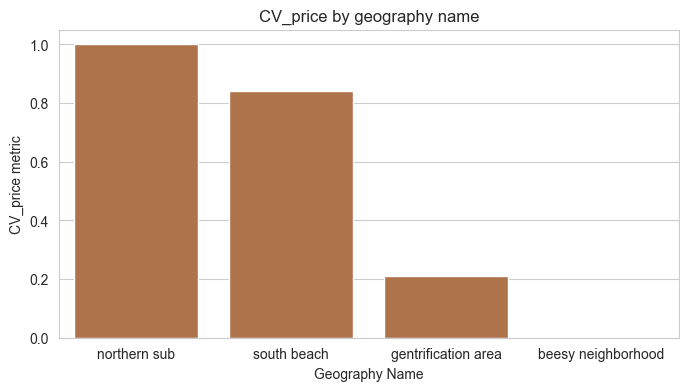

In [46]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 4))
sns.barplot(data=CV_price_summary, x='geography_name', y='CV_price', color='#BF6F3B')

# add labels
plt.xlabel('Geography Name')
plt.ylabel('CV_price metric')
plt.title('CV_price by geography name')

# show the plot
plt.show()

##### Discussion 
- Based on this metric Northern sub and South beach are the two most competitive areas, therefore there is a need for bigger discount

#### CV_score_distribution

In [47]:
# average ranking score for each geographic area
avg_rank_ga = df.groupby('geography_name')['ranking_score'].mean().reset_index()
avg_rank_ga.rename(columns={"ranking_score": "mean"}, inplace=True)

# standard deviation of ranking scores for each geographic area
std_rank_ga = df.groupby('geography_name')['ranking_score'].std().reset_index()
std_rank_ga.rename(columns={"ranking_score": "std"}, inplace=True)

ranking = pd.merge(avg_rank_ga, std_rank_ga, on='geography_name')

# competitiveness metric based on ranking
ranking['CV_score_distribution'] = ranking['mean'] / ranking['std'] 
ranking = ranking.sort_values('CV_score_distribution', ascending=False)
CV_score_distribution_summary = ranking.loc[:, ['geography_name', 'CV_score_distribution']].round(2)
print(CV_score_distribution_summary)

        geography_name  CV_score_distribution
2         northern sub                   3.88
1  gentrification area                   3.86
3          south beach                   3.69
0   beesy neighborhood                   3.35


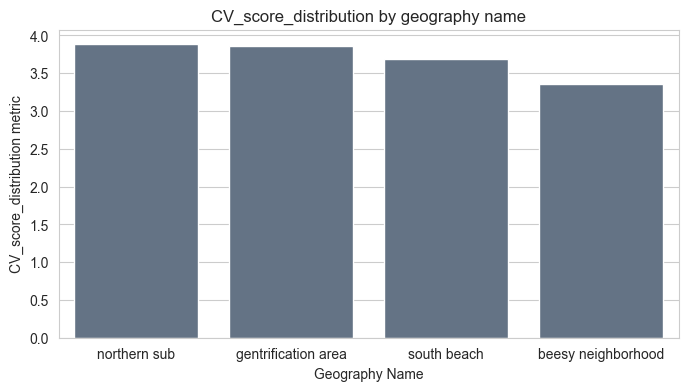

In [48]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 4))
sns.barplot(data=CV_score_distribution_summary, x='geography_name', y='CV_score_distribution', color='#5E738B')

# add labels
plt.xlabel('Geography Name')
plt.ylabel('CV_score_distribution metric')
plt.title('CV_score_distribution by geography name')

# show the plot
plt.show()

##### Discussion 
- Based on this metric Northern sub and Gentrification area South are the two most competitive areas, therefore there is a need for bigger discount. 
- South beach is also close

##### Conclusion on the 3 metrics
- Based on the 3 metrics, it is observed that Northern sub and South beach are the two areas with the most competitiveness.  

### Assignment Part 3
The product team of SpaN wants to launch a new page on the portal that would help agents decide the correct price they should set for a property for sale in Athens. The agent would need to input certain attributes of a property and an algorithm would value the property, based on historical data. The team is building an MVP (minimum viable product) that would be launched in beta, in order to measure the willingness of agents to use the new page and get feedback on the accuracy of the predictions, based on the experience of agents in the market.

They ask if you could help them identify what are the most important attributes that an agent would have to input to get a valid prediction of a property’s price valuation and also build the model that would predict the value (price).

Using the data from the given dataset:
- Identify the most important attributes in predicting the price of a property.
- Build a model that valuates each residential property

#### Solution 

In [49]:
df.drop(columns = ['id', 'agent_id'], inplace = True) # In this problem 'id', 'agent_id' are not needed anymore

In [50]:
# Devide the columns into categorical and numerical
categorical_attributes = df.select_dtypes(include=['object']).columns
numerical_attributes = df.select_dtypes(include=['number']).columns
numerical_attributes_noprice = df.select_dtypes(include=['number']).columns.drop('price')

In [51]:
# train-test split
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# preprocessing steps for the categorical and numerical columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = MinMaxScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_attributes),
        ('num', numeric_transformer, numerical_attributes_noprice)
    ])

#### Evaluation of 3 ML models for the predictions of house prices (all input variables are taken into account)

In [52]:
results = evaluate_predictions_of_prices()

{'GradientBoostingRegressor': {'rmse': 232139.04, 'mape': 138908.47, 'train_rmse': 221300.97, 'train_mape': 133297.85}, 'RandomForestRegressor': {'rmse': 203270.85, 'mape': 114687.65, 'train_rmse': 78578.51, 'train_mape': 43054.27}, 'XGBRegressor': {'rmse': 214807.17, 'mape': 125760.47, 'train_rmse': 106625.35, 'train_mape': 68060.23}}


#### Discussion
- From the chosen models RandomForestRegressor achieves the best metrics
- In this problem, extra models could be applied such as DNNs
- The variables could be normalized with a different way

#### Identify the most important attributes

In [53]:
important_feat = most_important(n_features=20)

{'GradientBoostingRegressor': {'top_features': ['alarm', 'floor', 'ranking_score', 'ad_type', 'playroom', 'airy', 'holiday_home', 'elevator', 'fireplace', 'for_commercial_use', 'pool', 'double_glass', 'corner', 'student_home', 'sq_meters', 'renovated', 'solar_heater', 'penthouse', 'no_of_bathrooms', 'painted']}, 'RandomForestRegressor': {'top_features': ['alarm', 'floor', 'penthouse', 'ranking_score', 'ad_type', 'corner', 'holiday_home', 'student_home', 'airy', 'playroom', 'sq_meters', 'no_of_bathrooms', 'neoclassic', 'double_glass', 'night_power', 'painted', 'furnished', 'home_years', 'fireplace', 'unfinished']}, 'XGBRegressor': {'top_features': ['alarm', 'floor', 'ad_type', 'ranking_score', 'pool', 'solar_heater', 'playroom', 'home_years', 'airy', 'painted', 'renovated', 'no_of_bathrooms', 'balcony_area', 'for_commercial_use', 'elevator', 'living_rooms', 'furnished', 'night_power', 'sq_meters', 'holiday_home']}}


#### Discussion 
- Based on the GradientBoostingRegressor the 5 most important attributes with descending importance are:'alarm', 'floor', 'ranking_score', 'ad_type', 'playroom'
- Based on the 'RandomForestRegressor' the 5 most important attributes with descending importance are:'alarm', 'floor', 'penthouse', 'ranking_score', 'ad_type'
- Based on the 'XGBRegressor' the 5 most important attributes with descending importance are: 'alarm', 'floor', 'ad_type', 'ranking_score', 'pool'
- Alternative ways to find the most important attributes could be the use of correlation matrix(only for numerical attributes), the Recursive Feature Elimination (RFE) technique, Lasso Regression, Principal Component Analysis

#### Common important features derived from the 3 models

In [54]:
common_features_list=common_features(important_feat)
common_features_list

['holiday_home',
 'playroom',
 'floor',
 'airy',
 'alarm',
 'no_of_bathrooms',
 'ranking_score',
 'ad_type',
 'sq_meters',
 'painted']

#### Evaluation of 3 ML models for the predictions of house prices (input : only common important features derived from the 3 models)

In [55]:
X_train_top_features = X_train[common_features_list]
X_test_top_features = X_test[common_features_list]

categorical_attr = X_train_top_features.select_dtypes(include=['object']).columns
numerical_attr = X_train_top_features.select_dtypes(include=['number']).columns

# preprocessing steps for the categorical and numerical columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = MinMaxScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_attr),
        ('num', numeric_transformer, numerical_attr)
    ])

In [56]:
results_top = evaluate_predictions_of_prices_for_top_features()

{'GradientBoostingRegressor': {'rmse': 275848.66, 'mape': 177773.01, 'train_rmse': 264675.67, 'train_mape': 171655.64}, 'RandomForestRegressor': {'rmse': 278276.09, 'mape': 172207.49, 'train_rmse': 103392.29, 'train_mape': 63477.75}, 'XGBRegressor': {'rmse': 275708.12, 'mape': 173369.03, 'train_rmse': 173989.41, 'train_mape': 116296.02}}


#### Discussion
- From the chosen models RandomForestRegressor achieves the best metrics
- The use of less input variables leads to worse results. Probably the information that is discarded was important for the model 
- If we choose more input variables maybe we can achieve better scores.
